# Statistics

In [1]:
%load_ext autoreload
%autoreload 2

## Graph statistics

In [ ]:
import graph_helper
import dataset_helper
import matplotlib.pyplot as plt
from IPython.display import display

for graph_cache_file in dataset_helper.get_all_cached_graph_datasets():
    if 'ana' in graph_cache_file: continue
    if 'gml' not in graph_cache_file: continue
    cache_filename = graph_cache_file.split('/')[-1]
    print('{} {}'.format('#' * 20, cache_filename))
    X, Y = dataset_helper.get_dataset_cached(graph_cache_file)
    num_classes = min(len(set(X)), 20)
    #dataset_helper.plot_dataset_class_distribution(X, Y, title = graph_cache_file, figsize=(12, num_classes * 0.8))
    df = graph_helper.get_graph_stats(X, Y)
    
    ax = df['num_graphs'].plot.barh(title = 'Graphs per topic\n(Dataset: {})'.format(cache_filename.replace('.npy', '')), legend = True, figsize = (14, 8))
    ax.set_xlabel('# graphs')
    display(df)
    plt.show()
    break

In [3]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set('notebook', 'white')

df_all = None
for result_file in glob('data/results/*.npy'):
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 4)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    if is_graph_dataset:
        result['wl_iteration'] = int(dataset.split('.')[-1])
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            #result['window_size'] = -1
            dataset_name = parts[3].split('.')[0]
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
    for param in result['params']:
        del param['clf']
    if dataset_name.endswith('-single'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    result['dataset'] = dataset_name
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    
    if df_all is None:
        df_all = result_df
    else:
        df_all = df_all.append(result_df)

#df_all['window_size'].fillna('concept-graph', inplace = True)

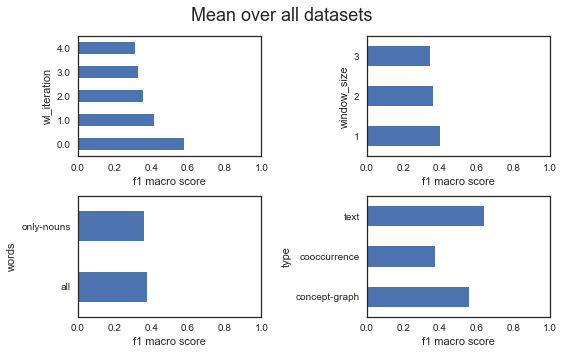

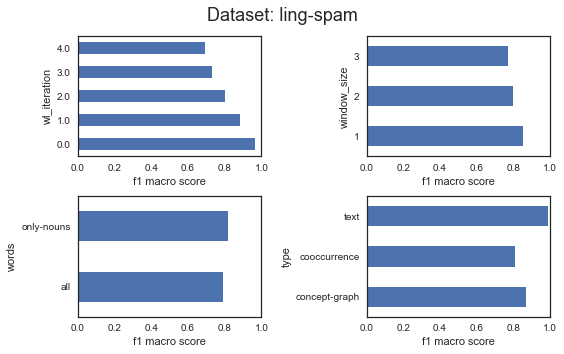

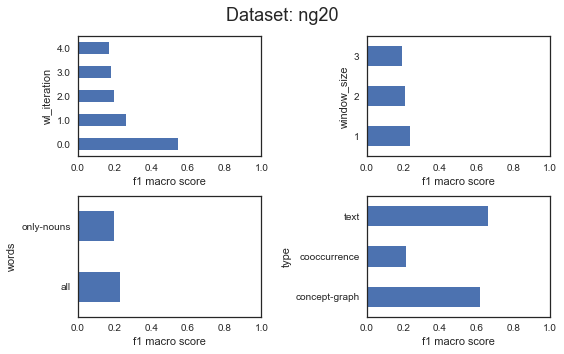

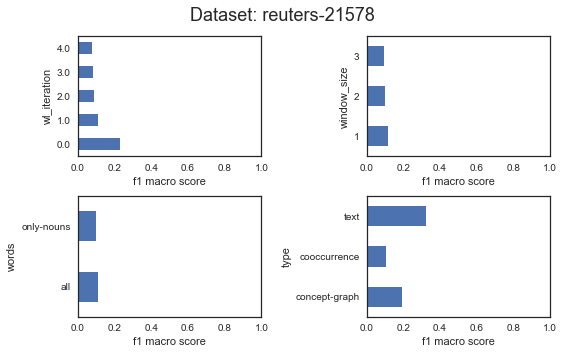

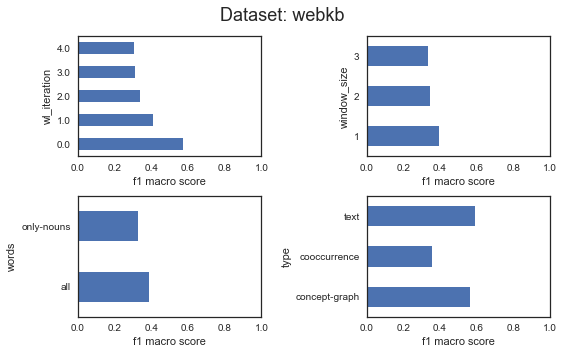

In [4]:
def plot_distributions(df, title = None, figsize = (8, 5)):
    fig, axes_indexed = plt.subplots(nrows = 2, ncols=2, figsize = figsize)

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type'], axes):
        df.groupby(val).mean_test_score.mean().plot(kind = 'barh', ax = ax, xlim = (0, 1))
        ax.set_xlabel('f1 macro score')
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig, axes
    
df_all = df_all.groupby('dataset').filter(lambda x: len(x.type.value_counts()) == 3).reset_index(drop=True)
fig, _  = plot_distributions(df_all, title = 'Mean over all datasets')
fig.savefig('tmp/results/all.png', dpi = 100)
plt.show()
plt.close(fig)
for name, df_dataset in df_all.groupby('dataset'):
    if len(df_dataset.type.value_counts()) < 3:
        continue
    fig, _ = plot_distributions(df_dataset, title = 'Dataset: {}'.format(name))
    fig.savefig('tmp/results/dataset-{}.png'.format(name), dpi = 100)
    plt.show()
    plt.close(fig)


In [ ]:
def plot_best_by_type(df, title = '', figsize = (8, 3)):
    fig, ax = plt.subplots(figsize = figsize)
    df['mean_test_score'].max().plot(kind = 'barh', ax = ax, xlim = (0, 1))
    fig.suptitle(title, fontsize = 16)
    fig.tight_layout()
    fig.subplots_adjust(top = 0.9)
    return fig, ax

for name, df_dataset in df_all.groupby('dataset'):
    df_dataset_grouped_by_type = df_dataset.groupby('type')
    fig, ax = plot_best_by_type(df_dataset_grouped_by_type, 'Dataset: {} (best)'.format(name))
    fig.savefig('tmp/results/dataset-{}-best.png'.format(name), dpi = 100)
    plt.show()
    plt.close(fig)

In [ ]:
import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embedding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            if embedding == 'trained' and 'coo' in  dataset_file:
                print('Yes', counts['counts']['not_found'], not_found_ratio, '%', counts['not_found_sample'])
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][0][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df#[df.index == "ng20"]